In [116]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# 기상청 - 날씨 데이터

In [46]:
w = pd.read_csv(os.path.join('..', '..', '0.Data', '03_외부데이터', '2019_weather.csv'), encoding = 'cp949')

/Users/jinseok/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
w.shape

(122640, 37)

In [48]:
w['지점명'].value_counts()

수원     8760
동두천    8760
광주     8760
서울     8760
대구     8760
대전     8760
백령도    8760
강화     8760
부산     8760
이천     8760
양평     8760
인천     8760
울산     8760
파주     8760
Name: 지점명, dtype: int64

In [49]:
dic = {
    '서울' : '서울',
    '부산' : '부산',
    '대구' : '대구',
    '인천' : ['강화', '인천', '백령도'],
    '광주' : '광주',
    '대전' : '대전',
    '울산' : '울산',
    '경기' : ['동두천', '이천', '양평', '수원', '파주']
}

In [50]:
w.loc[w['지점명'].isin(dic['경기']), '지점명'] = '경기_' + w.loc[w['지점명'].isin(dic['경기']), '지점명']
w.loc[w['지점명'].isin(dic['인천']), '지점명'] = '인천_' + w.loc[w['지점명'].isin(dic['인천']), '지점명']

In [51]:
w['지점명'].apply(lambda x : x[:2]).value_counts()

경기    43800
인천    26280
광주     8760
서울     8760
대구     8760
대전     8760
부산     8760
울산     8760
Name: 지점명, dtype: int64

In [52]:
# 결측치 파악하기

In [53]:
# 강수량 제외 50% 이상 결측지 칼럼 제외
(w.isnull().sum() / w.shape[0]).sort_values(ascending = False)

지면상태(지면상태코드)     1.000000
풍속 QC플래그         0.999609
풍향 QC플래그         0.999609
3시간신적설(cm)       0.999527
적설(cm)           0.995336
현지기압 QC플래그       0.962712
해면기압 QC플래그       0.962688
습도 QC플래그         0.962141
기온 QC플래그         0.961619
지면온도 QC플래그       0.957200
강수량(mm)          0.917694
강수량 QC플래그        0.846632
현상번호(국내식)        0.793436
30cm 지중온도(°C)    0.714310
20cm 지중온도(°C)    0.714269
10cm 지중온도(°C)    0.714269
5cm 지중온도(°C)     0.714269
일사(MJ/m2)        0.687622
운형(운형약어)         0.638120
일조 QC플래그         0.547285
최저운고(100m )      0.534418
일조(hr)           0.453563
중하층운량(10분위)      0.014995
시정(10m)          0.005202
전운량(10분위)        0.004672
지면온도(°C)         0.001305
습도(%)            0.001223
풍향(16방위)         0.001215
풍속(m/s)          0.001215
이슬점온도(°C)        0.001093
증기압(hPa)         0.001084
해면기압(hPa)        0.000685
현지기압(hPa)        0.000660
기온(°C)           0.000660
일시               0.000000
지점명              0.000000
지점               0.000000
dtype: float64

In [54]:
drop_columns = list((w.isnull().sum() / w.shape[0]).sort_values(ascending = False).index[:19])

In [55]:
drop_columns.remove('강수량(mm)')

In [56]:
w = w.drop(drop_columns, axis = 1)

In [57]:
w['지점명'].value_counts()

경기_이천     8760
광주        8760
경기_동두천    8760
서울        8760
대구        8760
대전        8760
경기_양평     8760
인천_강화     8760
인천_인천     8760
인천_백령도    8760
경기_파주     8760
부산        8760
경기_수원     8760
울산        8760
Name: 지점명, dtype: int64

In [58]:
# 인천-백령도 삭제
w = w.loc[w['지점명'] != '인천_백령도']

1. 강수량
2. 기온
3. 습도
4. 풍속
5. 체감온도(식으로 계산)
6. 시정
7. 지면온도
8. 미세먼지 전체

In [63]:
w = w.drop(['지점', '풍향(16방위)', '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '일조(hr)', '일조 QC플래그', '전운량(10분위)', '중하층운량(10분위)', '최저운고(100m )'], axis = 1)

In [64]:
# 체감온도 : 13.12 + 0.6215T - 11.37V^0.16 + 0.3965V^0.16T
# T : 기온((°C))
# V : 풍속(km/h)

In [74]:
w['체감온도'] = w.apply(lambda x: 13.12 + 0.6215 * x['기온(°C)'] - 11.37 * (x['풍속(m/s)'] * 3.6)**0.16 + 0.3965 * (x['풍속(m/s)'] * 3.6)**0.16 * x['기온(°C)'], axis = 1)

In [81]:
w.to_csv(os.path.join('..', '..', '0.Data', '03_외부데이터', '전처리', 'prep_2019_weather.csv'), encoding = 'cp949', index = False)

# 에어코리아 - 미세먼지 데이터

In [118]:
dust = pd.DataFrame()
for i in tqdm(range(1, 13)):
    temp = pd.read_excel(os.path.join('..', '..', '0.Data', '03_외부데이터', '2019_dust', '2019년 {}월.xlsx'.format(i)))
    dust = pd.concat([dust, temp], axis = 0)

100%|██████████| 12/12 [07:41<00:00, 38.47s/it]


In [119]:
dust.shape

(3957129, 12)

In [120]:
dust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3957129 entries, 0 to 357832
Data columns (total 12 columns):
 #   Column  Dtype  
---  ------  -----  
 0   지역      object 
 1   망       object 
 2   측정소코드   int64  
 3   측정소명    object 
 4   측정일시    int64  
 5   SO2     float64
 6   CO      float64
 7   O3      float64
 8   NO2     float64
 9   PM10    float64
 10  PM25    float64
 11  주소      object 
dtypes: float64(6), int64(2), object(4)
memory usage: 392.5+ MB


In [28]:
dust.head()

,지역,망,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,PM25,주소
0,서울 중구,도시대기,111121,중구,2019010101,0.003,0.7,0.003,0.054,39.0,24.0,서울 중구 덕수궁길 15
1,서울 중구,도시대기,111121,중구,2019010102,0.003,0.8,0.002,0.056,38.0,27.0,서울 중구 덕수궁길 15
2,서울 중구,도시대기,111121,중구,2019010103,0.003,0.9,0.002,0.057,42.0,28.0,서울 중구 덕수궁길 15
3,서울 중구,도시대기,111121,중구,2019010104,0.003,0.8,0.002,0.054,42.0,31.0,서울 중구 덕수궁길 15
4,서울 중구,도시대기,111121,중구,2019010105,0.003,0.8,0.002,0.048,49.0,33.0,서울 중구 덕수궁길 15


In [61]:
dust = dust.loc[dust['지역'].str.contains('서울|경기|인천|부산|울산|대구|대전|광주')]

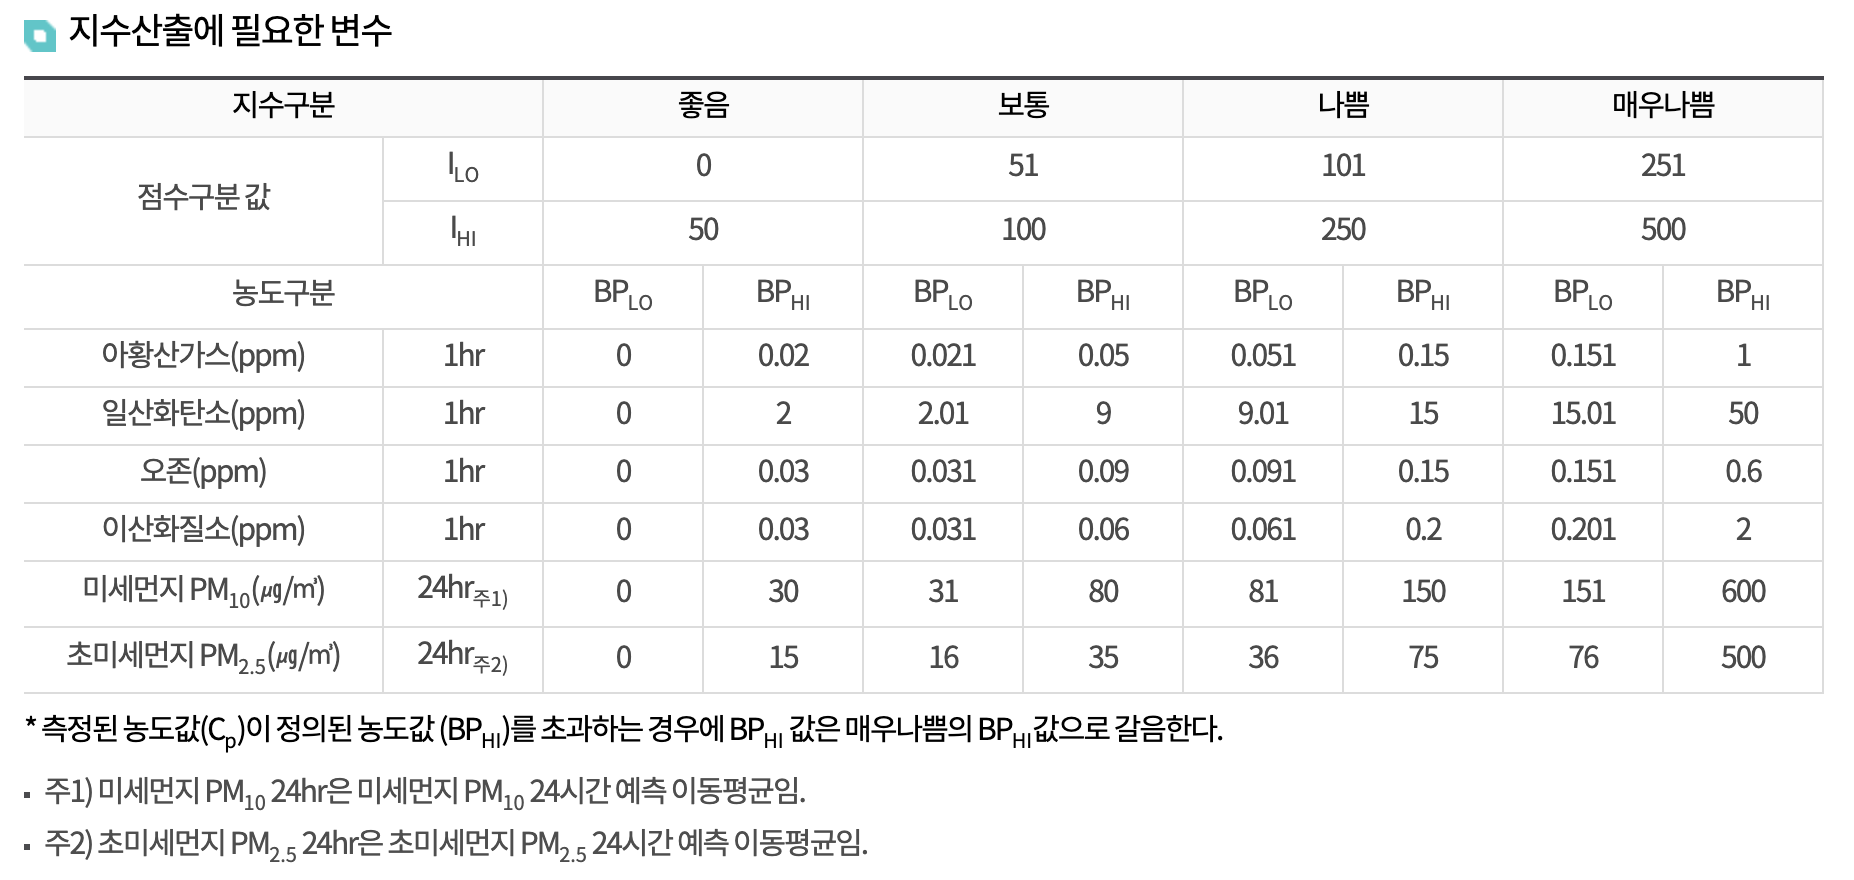

In [69]:
dust['상위지역'] = dust['지역'].apply(lambda x : x[:2])

/Users/jinseok/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [89]:
prep_dust = dust.groupby(['상위지역', '측정일시']).agg({
    'PM10' : [('최고PM10', np.max), ('최저PM10', np.min), ('평균PM10', np.mean)],
    'PM25' : [('최고PM25', np.max), ('최저PM25', np.min), ('평균PM25', np.mean)]
}).reset_index()

In [90]:
prep_dust

상위지역        측정일시   PM10                     PM25                  
                       최고PM10 최저PM10     평균PM10 최고PM25 최저PM25     평균PM25
0       경기  2019010101   84.0   25.0  43.238636   54.0   14.0  27.411111
1       경기  2019010102   80.0   21.0  44.550562   49.0   12.0  28.977778
2       경기  2019010103   74.0   24.0  45.168539   51.0   11.0  30.166667
3       경기  2019010104   79.0   21.0  44.910112   50.0   11.0  31.044444
4       경기  2019010105   76.0   25.0  44.404494   54.0   15.0  30.477778
...    ...         ...    ...    ...        ...    ...    ...        ...
70075   인천  2019123120   33.0    9.0  19.000000   22.0    5.0  10.481481
70076   인천  2019123121   36.0    8.0  19.035714   20.0    5.0  11.370370
70077   인천  2019123122   37.0   10.0  20.928571   21.0    7.0  12.629630
70078   인천  2019123123   34.0    9.0  22.107143   24.0    7.0  13.370370
70079   인천  2019123124   37.0   10.0  22.892857   27.0    8.0  14.148148

[70080 rows x 8 columns]

In [91]:
prep_dust.columns = ['상위지역', '측정일시', '최고PM10', '최저PM10', '평균PM10', '최고PM25', '최저PM25', '평균PM25']

In [92]:
prep_dust['상위지역'].value_counts()

인천    8760
울산    8760
대구    8760
경기    8760
부산    8760
대전    8760
서울    8760
광주    8760
Name: 상위지역, dtype: int64

In [ ]:
# dust['PM10']dust['PM10'].apply(lambda x : '좋음' if x < 31 else ('보통' if 30 < x < 81 else ('나쁨' if 80 < x < 151 else '매우나쁨'))).value_counts()

In [133]:
prep_dust['측정일시'] = prep_dust['측정일시'].astype(str).apply(lambda x : x[:8] + '00' if x[8:] == '24' else x)

In [135]:
prep_dust['측정일시'] = pd.to_datetime(prep_dust['측정일시'].astype(str).apply(lambda x : '-'.join((x[:4], x[4:6], x[6:8])) + ' '+ x[8:] + ':00:00'))

In [145]:
from datetime import timedelta

In [148]:
prep_dust.loc[prep_dust['측정일시'].dt.hour == 0, '측정일시'] = prep_dust.loc[prep_dust['측정일시'].dt.hour == 0, '측정일시'] + timedelta(days = 1)

In [152]:
prep_dust.to_csv(os.path.join('..', '0.Data', '03_외부데이터', '전처리', 'prep_2019_dust.csv'), encoding = 'cp949', index = False)

# 날짜별 지역별 피벗테이블 생성

In [35]:
# merge를 위한 년도/월/시간 생성

In [88]:
def prepColumns(df):
    df.columns = list(map(lambda x : '_'.join(x), df.columns))
    return df

In [89]:
def makeDate(df):
    df['월'] = df['날짜'].dt.month
    df['일'] = df['날짜'].dt.day
    df['시간'] = df['날짜'].dt.hour.apply(lambda x : 24 if x == 0 else x)
    return df

In [90]:
prep_w = pd.read_csv(os.path.join('..', '..', '0.Data', '03_외부데이터', '전처리', 'prep_2019_weather.csv'), encoding = 'cp949')
prep_dust = pd.read_csv(os.path.join('..', '..', '0.Data', '03_외부데이터', '전처리', 'prep_2019_dust.csv'), encoding = 'cp949')

In [94]:
# datetime 변경
prep_w['일시'] = pd.to_datetime(prep_w['일시'])
prep_dust['측정일시'] = pd.to_datetime(prep_dust['측정일시'])

In [95]:
prep_w = prep_w.loc[prep_w['지점명'].str.contains('파주|동두천|양평|이천|강화') == False]

In [96]:
pb_weather = pd.pivot_table(prep_w, index = '일시', columns = '지점명')
pb_dust = pd.pivot_table(prep_dust, index = '측정일시', columns = '상위지역')

In [97]:
pb_weather = prepColumns(pb_weather)
pb_dust = prepColumns(pb_dust)

In [98]:
pb_weather = pb_weather.reset_index().rename(columns = {'일시' : '날짜'})
pb_dust = pb_dust.reset_index().rename(columns = {'측정일시' : '날짜'})

In [105]:
pb_weather = makeDate(pb_weather)
pb_dust = makeDate(pb_dust)

In [106]:
pb_weather.to_csv(os.path.join('..', '..', '0.Data', '03_외부데이터', '전처리', 'prep_2019_pb_weather.csv'), encoding = 'cp949', index = False)

In [ ]:
pb_dust.to_csv(os.path.join('..', '..', '0.Data', '03_외부데이터', '전처리', 'prep_2019_pb_dust.csv'), encoding = 'cp949', index = False)er.to_csv(os.path.join('..', '..', '0.Data', '03_외부데이터', '전처리', 'prep_2019_pb_weather.csv'), encoding = 'cp949', index = False)

In [112]:
prep_w['일시'].dt.year
prep_w['일시'].dt.month
prep_w['일시'].dt.day
prep_w['일시'].dt.hour

17520    2019
17521    2019
17522    2019
17523    2019
17524    2019
         ... 
87595    2019
87596    2019
87597    2019
87598    2019
87599    2020
Name: 일시, Length: 70080, dtype: int64

In [113]:
prep_w

,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),시정(10m),지면온도(°C),체감온도
17520,서울,2019-01-01 01:00:00,-5.9,NaN,1.8,56.0,1569.0,-6.5,-9.033953
17521,서울,2019-01-01 02:00:00,-6.5,NaN,1.2,60.0,1462.0,-7.1,-8.546246
17522,서울,2019-01-01 03:00:00,-6.9,NaN,2.2,62.0,1281.0,-7.3,-10.810783
17523,서울,2019-01-01 04:00:00,-7.2,NaN,1.2,57.0,1195.0,-7.5,-9.332063
17524,서울,2019-01-01 05:00:00,-7.6,NaN,2.1,59.0,1248.0,-7.8,-11.483797
...,...,...,...,...,...,...,...,...,...
87595,부산,2019-12-31 20:00:00,-1.0,NaN,1.4,21.0,2000.0,-0.3,-2.743297
87596,부산,2019-12-31 21:00:00,-1.4,NaN,3.0,21.0,2000.0,-0.7,-5.200679
87597,부산,2019-12-31 22:00:00,-1.9,NaN,1.5,24.0,2000.0,-0.8,-3.939210
87598,부산,2019-12-31 23:00:00,-2.3,NaN,2.1,24.0,2000.0,-1.1,-5.285272
